# Road Lane Detection using U-Net

In [30]:
# import required libraries/dependencies
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, concatenate, Dropout
import os
import cv2
import matplotlib.pyplot as plt
import json
from keras.models import load_model

# Preprocessing Images and Labels

In [5]:
# Function to preprocess images
def image_preprocessing(image_path, target_size=(256, 256)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize pixel values
    return image

# Function to preprocess labels (creating binary masks for lanes)
def label_preprocessing(label_path, target_size=(256, 256)):
    mask = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, target_size)
    mask = mask / 255.0  # Normalize pixel values
    mask = np.expand_dims(mask, axis=-1)
    return mask

# Function to load data from JSON files
def TuSimple_data(image_base_path, label_base_path):
    image_paths = []
    label_paths = []
    images = []
    labels = []

    for root, _, files in os.walk(image_base_path):
        for file in files:
            if file.endswith('.jpg'):
                image_path = os.path.join(root, file)
                label_path = image_path.replace(image_base_path, label_base_path).replace('.jpg', '.png')
                if os.path.exists(label_path):
                    image_paths.append(image_path)
                    label_paths.append(label_path)

    return image_paths, label_paths

# Example usage
image_directory = '/kaggle/input/tusimple/TUSimple/train_set/clips'
label_directory = '/kaggle/input/tusimple/TUSimple/train_set/seg_label'

images, labels = TuSimple_data(image_directory, label_directory)

# Visualize a sample image

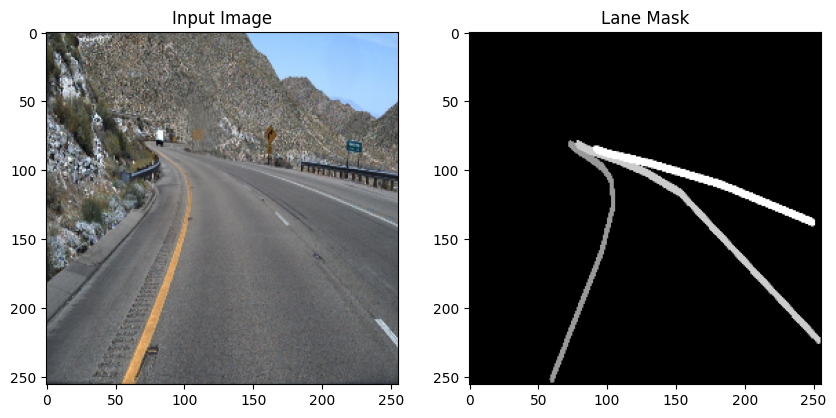

In [35]:
# Preprocess a sample image and label
sample_image_path = images[0]
sample_label_path = labels[0]
sample_image = image_preprocessing(sample_image_path)
sample_label = label_preprocessing(sample_label_path)

# Visualize the preprocessed image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(sample_image)
plt.subplot(1, 2, 2)
plt.title('Lane Mask')
plt.imshow(sample_label.squeeze(), cmap='gray')
plt.show()

# Data Generator 

In [37]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence # base class to create data generator for training the model.

class UNET_DataGenerator(Sequence):
    def __init__(self, image_paths, label_paths, batch_size=32, target_size=(256, 256)):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_image = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_label = self.label_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = np.array([image_preprocessing(image_path, self.target_size) for image_path in batch_image])
        masks = np.array([label_preprocessing(label_path, target_size=self.target_size) for label_path in batch_label])

        return images, masks

# Data Generator to split dataset into Train, Validation and Test sets

In [16]:
# Create data generators for train, validation and test sets
batch_size = 32
train_generator = UNET_DataGenerator(images[:int(0.75*len(images))], labels[:int(0.75*len(labels))], batch_size)
val_generator = UNET_DataGenerator(images[int(0.75*len(images)):int(0.9*len(images))], labels[int(0.75*len(labels)):int(0.9*len(labels))], batch_size)
test_generator = UNET_DataGenerator(images[int(0.9*len(images)):], labels[int(0.9*len(labels)):], batch_size)

# U-NET Architecture

In [20]:
def UNET(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    drop5 = Dropout(0.4)(c5)
    
    # Decoder
    u6 = UpSampling2D((2, 2))(drop5)
    u6 = Conv2D(512, (2, 2), activation='relu', padding='same')(u6)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Conv2D(256, (2, 2), activation='relu', padding='same')(u7)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Conv2D(128, (2, 2), activation='relu', padding='same')(u8)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = Conv2D(64, (2, 2), activation='relu', padding='same')(u9)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Intializing Model Object

In [21]:
model = UNET()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ conv2d_9[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ dropout[0][0]   

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

tensorboard_log_dir = 'logs'

#Create a Tensorflow callback
tensorboard_callback = TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1)

epochs = 15
batch_size = 32
#Add TensorBoard callbacks to the list of callbacks
callbacks = [
    ModelCheckpoint('best_model.keras', save_best_only=True),
    tensorboard_callback ]

history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, batch_size=batch_size, callbacks = callbacks)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-06-27 13:54:07.825737: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,256,256]{3,2,1,0}, f32[32,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-27 13:54:11.202815: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 4.377186454s
Trying algorithm eng0{} for conv (f32[64,6

84/84 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - accuracy: 0.9519 - loss: 0.2634 - val_accuracy: 0.9555 - val_loss: 0.0048
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.9561 - loss: 0.0047 - val_accuracy: 0.9555 - val_loss: 0.0047
Epoch 3/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.9563 - loss: 0.0045 - val_accuracy: 0.9555 - val_loss: 0.0046
Epoch 4/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.9558 - loss: 0.0044 - val_accuracy: 0.9555 - val_loss: 0.0044
Epoch 5/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.9566 - loss: 0.0041 - val_accuracy: 0.9555 - val_loss: 0.0042
Epoch 6/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.9559 - loss: 0.0040 - val_accuracy: 0.9555 - val_loss: 0.0039
Epoch 7/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.9558 - loss: 0.0038 - val_accuracy: 0.9555 - val_loss: 0.0038
Epoch 8/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.9558 - loss: 0.0036 - val_accuracy: 0.9555 - val_loss: 0.

# Graphical Visualization of Training and Validation Accuracy and Loss

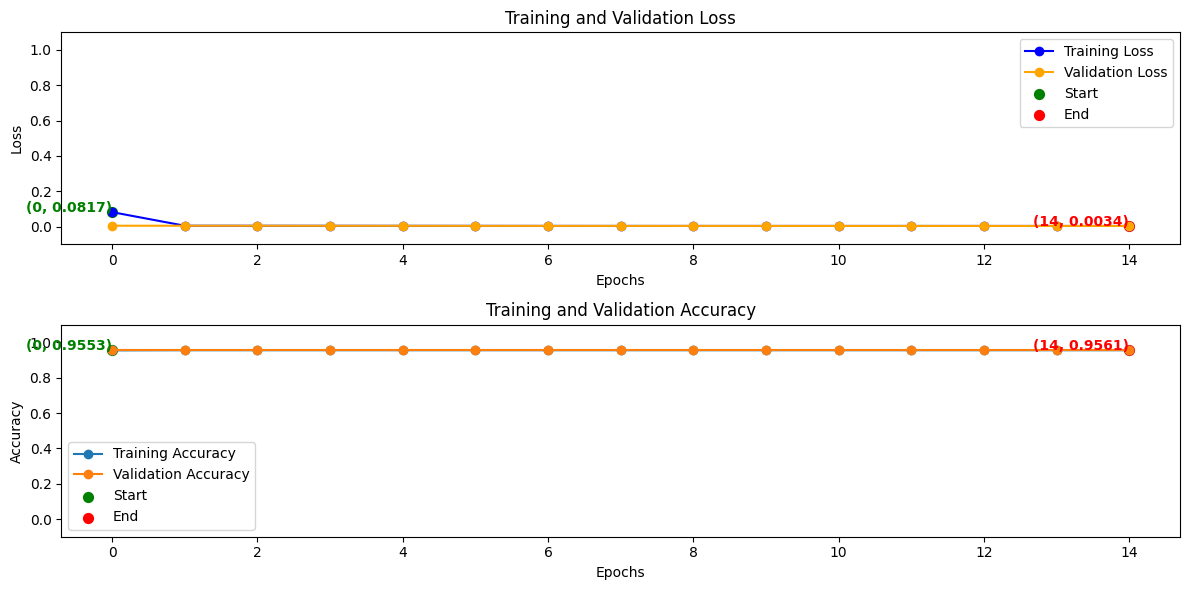

In [23]:
# Plotting Training and Validation metrics with dot markers for starting and ending points
plt.figure(figsize=(12, 6))

# Plotting Training and Validation Loss
plt.subplot(2, 1, 1) # Two subplots in a vertical arrangement

plt.plot(history.history['loss'], label='Training Loss',marker = 'o', color = 'blue')
plt.plot(history.history['val_loss'], label='Validation Loss',marker = 'o', color = 'orange')

# Display values for starting and endpoints on the loss plot
start_loss_coord = (0, history.history['loss'][0])
end_loss_coord = (len(history.history['loss']) - 1, history.history['loss'][-1])
plt.text(*start_loss_coord, f'({start_loss_coord[0]}, {start_loss_coord[1]:.4f})', color='green', fontsize = 10, ha = "right", weight ='bold')
plt.text(*end_loss_coord, f'({end_loss_coord[0]}, {end_loss_coord[1]:.4f})', color='red', fontsize = 10, ha = "right", weight ='bold')

# Dot marker for Starting Point
plt.scatter(*start_loss_coord, color = 'green', s = 50, label='Start')

# Dot marker for Ending Point
plt.scatter(*end_loss_coord, color = 'red', s = 50, label='End')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(-0.1, 1.1) # Set y-axis limits for loss with padding

plt.subplot(2, 1, 2) # subplot for accuracy

# Plotting Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', marker = 'o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker = 'o')

# Display values for starting and endpoints on the accuracy plot
start_accuracy_coord = (0, history.history['accuracy'][0])
end_accuracy_coord = (len(history.history['accuracy']) - 1, history.history['accuracy'][-1])
plt.text(*start_accuracy_coord, f'({start_accuracy_coord[0]}, {start_accuracy_coord[1]:.4f})', color='green', fontsize = 10, ha = "right", weight ='bold')
plt.text(*end_accuracy_coord, f'({end_accuracy_coord[0]}, {end_accuracy_coord[1]:.4f})', color='red', fontsize = 10, ha = "right", weight ='bold')

# Dot marker for Starting Point
plt.scatter(*start_accuracy_coord, color = 'green', s = 50, label='Start')

# Dot marker for Ending Point
plt.scatter(*end_accuracy_coord, color = 'red', s = 50, label='End')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(-0.1, 1.1) # Set y-axis limits for accuracy with padding

#Adjust Layout for better visualization
plt.tight_layout()

# Save the plot to a file
plt.savefig('training_validation_plot.png')

# Show the plot
plt.show()

# Model Evaluation

In [24]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("test loss : {} and test accuracy: {}".format(test_loss, test_accuracy))

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 701ms/step - accuracy: 0.9557 - loss: 0.0035
test loss : 0.003515087068080902 and test accuracy: 0.9553733468055725


# Save the Evaluated Model

In [25]:
model.save('UNET_LANE_DETECTOR_WEIGHTS.h5')

# Calculate MSE and MAE on Test Generator

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

predicted_masks = []
true_masks = []

# Predictions on test images
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator[i]
    batch_predictions = model.predict(batch_images)
    predicted_masks.extend(batch_predictions)
    true_masks.extend(batch_labels)

# Converting lists to numpy arrays for calculations
predicted_masks = np.array(predicted_masks)
true_masks = np.array(true_masks)

# Flatten arrays for metric calculations
predicted_masks_flat = predicted_masks.flatten()
true_masks_flat = true_masks.flatten()

# Calculating MSE and MAE
mse = mean_squared_error(true_masks_flat, predicted_masks_flat)
mae = mean_absolute_error(true_masks_flat, predicted_masks_flat)

# Print or use the metrics as needed
print(f"MSE: {mse}")
print(f"MAE: {mae}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
MSE: 2.9529698201167586e-06
MAE: 0.00043607257293282723


# Visualize a prediction on sample image from TuSimple Dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


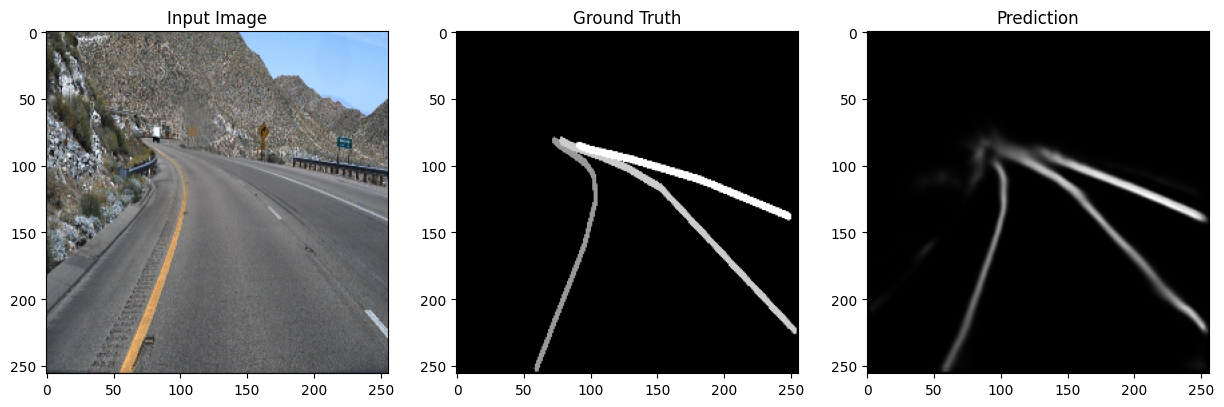

In [20]:
# Function to visualize predictions
def visualize_prediction(image, mask, prediction):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth')
    plt.imshow(mask.squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    plt.imshow(prediction.squeeze(), cmap='gray')

    plt.show()

# Visualize a sample prediction
sample_image = image_preprocessing(images[0])
sample_mask = label_preprocessing(labels[0])
sample_prediction = model.predict(np.expand_dims(sample_image, axis=0))

visualize_prediction(sample_image, sample_mask, sample_prediction)

# Predicting on New Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


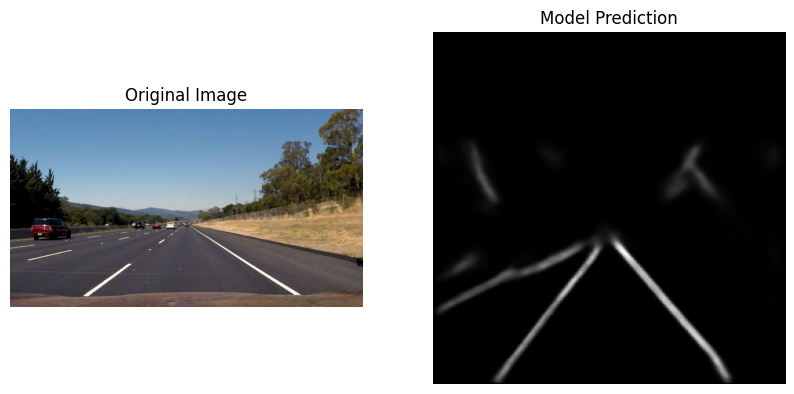

In [62]:
from keras.preprocessing import image

# Function to preprocess image
def preprocess_image(image_path, target_size=(256, 256)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize pixel values
    return image

# Function to predict lanes on a single image
def predict_on_image(model, img_path):
    img_array = preprocess_image(img_path)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)

    return prediction[0]

# Test the model on a new image
new_image_path = '/kaggle/input/road-pics/road1.jpeg'
prediction_result = predict_on_image(model, new_image_path)

# Save the prediction as a PNG image
output_image_path = '/kaggle/working/prediction_1.png'
plt.imsave(output_image_path, prediction_result.squeeze(), cmap='gray')

# Visualize the input image and the model's prediction
plt.figure(figsize=(10, 5))

# Displaying the original image
plt.subplot(1, 2, 1)
img = image.load_img(new_image_path)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Displaying the model's prediction
plt.subplot(1, 2, 2)
plt.imshow(prediction_result.squeeze(), cmap='gray')
plt.title('Model Prediction')
plt.axis('off')

plt.show()

# Overlaying Prediction on an Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


True

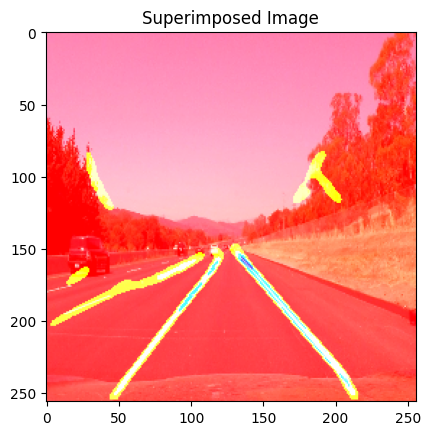

In [63]:
preprocessed_image = image_preprocessing(new_image_path) # preprocess image

mask = predict_on_image(model,new_image_path) # predict mask on image

mask = mask.squeeze()  # Remove batch dimension

mask = (mask - np.min(mask)) / (np.max(mask) - np.min(mask)) # Normalize image to [0:1]

# Resize mask to match the image size
mask_resized = cv2.resize(mask, (preprocessed_image.shape[1], preprocessed_image.shape[0]))

#apply blue-jet colormap on the image
mask_colored = cv2.applyColorMap(np.uint8(255 * mask_resized), cv2.COLORMAP_JET)

mask_colored = mask_colored.astype(np.float64)  # Ensure mask is of same type as image

# overlay mask on actual image
superimposed_image = cv2.addWeighted(preprocessed_image, 1.0, mask_colored, 0.3, 0.0)

# Show the superimposed image
plt.imshow(superimposed_image)
plt.title('Superimposed Image')

# Save the superimposed image
cv2.imwrite('/kaggle/working/superimposed_image.png',superimposed_image)

**Although there are slight disturbances, The prediction is pretty accurate since the model has successfully detected the lanes**